# 2B

In [536]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

random_state = 42

In [537]:
import joblib
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preprocessing

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas._libs.parsers import k
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [538]:
mvp_stats_2b = pd.read_csv("datasets/player_mvp_stats.csv", ';')
nicknames_df = pd.read_csv("datasets/nicknames.csv", ';')
salaries_2b = pd.read_csv("datasets/salaries.csv")
teams_2b = pd.read_csv("datasets/teams.csv", ';')
us_inflation_2b = pd.read_csv("datasets/US CPI.csv")

C:\Users\imman\AppData\Local\Temp\ipykernel_4168\3205523321.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  mvp_stats_2b = pd.read_csv("datasets/player_mvp_stats.csv", ';')
C:\Users\imman\AppData\Local\Temp\ipykernel_4168\3205523321.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  nicknames_df = pd.read_csv("datasets/nicknames.csv", ';')
C:\Users\imman\AppData\Local\Temp\ipykernel_4168\3205523321.py:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  teams_2b = pd.read_csv("datasets/teams.csv", ';')


In [539]:
# rename kolom supaya namanya tidak misleading
salaries_2b.rename({"Rank": "Salaries_Rank"}, axis=1, inplace=True)

### 2B. Preprocess dan merge beberapa dataset menjadi satu

In [540]:
def dataframe_to_dict(nicknames_df, key_column_name='Name', value_column_name='Abbreviation'):
    keys = nicknames_df[key_column_name]
    values = nicknames_df[value_column_name]
    return dict(zip(keys, values))

In [541]:
def cleaning_teamsdf_removeUnimportantRows(teams_2b):
    teams_2b = teams_2b.copy()
    important_rows = ~teams_2b.W.str.contains("Division")
    return teams_2b[important_rows]

def cleaning_teamsdf_convertStripToNan(teams_2b):
    teams_2b = teams_2b.copy()
    teams_2b.GB = teams_2b.GB.replace("—", np.NAN)
    return teams_2b

def cleaning_teamsdf_convertToAppropriateDatatype(teams_2b):
    """
    preconditions:
        cleaning_teamsdf_removeUnimportantRows
         cleaning_teamsdf_convertStripToNan
    """
    teams_2b = teams_2b.copy()
    teams_2b.W = pd.to_numeric(teams_2b.W)
    teams_2b.L = pd.to_numeric(teams_2b.L)
    teams_2b['W/L%'] = pd.to_numeric(teams_2b['W/L%'])
    teams_2b.GB = pd.to_numeric(teams_2b.GB)
    teams_2b['PS/G'] = pd.to_numeric(teams_2b['PS/G'])
    teams_2b['PA/G'] = pd.to_numeric(teams_2b['PA/G'])
    teams_2b.SRS = pd.to_numeric(teams_2b.SRS)
    return teams_2b

def cleaning_anyDf_removeStarInTeamName(teams_2b, column_name='Team'):
    teams_2b = teams_2b.copy()
    teams_2b[column_name] = teams_2b[column_name].str.replace('*', '')
    return teams_2b


def cleaning_anyDf_convertTeamNamesToItsAbbrev(teams_2b, nicknames_df, column_name='Team'):
    """
    precondition:
        teams df:
            cleaning_anyDf_removeStarInTeamName
    """
    nicknames_df = nicknames_df.copy()
    teams_2b = teams_2b.copy()

    nicknames_df = nicknames_df.drop_duplicates(subset='Name', keep='first')
    mapping = dataframe_to_dict(nicknames_df)
    mapping |= dataframe_to_dict(nicknames_df, 'Abbreviation', 'Abbreviation')

    teams_2b[column_name] = list(map(
        lambda x: mapping[x],
        teams_2b[column_name]
    ))
    return teams_2b

In [542]:
teams_2b = cleaning_teamsdf_removeUnimportantRows(teams_2b)
teams_2b = cleaning_teamsdf_convertStripToNan(teams_2b)
teams_2b = cleaning_teamsdf_convertToAppropriateDatatype(teams_2b)
teams_2b = cleaning_anyDf_removeStarInTeamName(teams_2b)
teams_2b = cleaning_anyDf_convertTeamNamesToItsAbbrev(teams_2b, nicknames_df)
teams_2b

C:\Users\imman\AppData\Local\Temp\ipykernel_4168\1280597476.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  teams_2b[column_name] = teams_2b[column_name].str.replace('*', '')


,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,683.0,NaN,111.5,105.7,5.22,1991,BOS
1,44,38,537.0,12.0,105.4,105.6,-0.39,1991,PHI
2,39,43,476.0,17.0,103.1,103.3,-0.43,1991,NYK
3,30,52,366.0,26.0,101.4,106.4,-4.84,1991,WSB
4,26,56,317.0,30.0,102.9,107.5,-4.53,1991,NJN
...,...,...,...,...,...,...,...,...,...
1028,42,30,583.0,NaN,112.4,110.2,2.26,2021,DAL
1029,38,34,528.0,4.0,113.3,112.3,1.07,2021,MEM
1030,33,39,458.0,9.0,111.1,112.8,-1.58,2021,SAS
1031,31,41,431.0,11.0,114.6,114.9,-0.20,2021,NOP


In [543]:
from datetime import datetime


def cleaning_inflationDf_separateDateColumns(us_inflation_2b, column='Yearmon', format="%d-%m-%Y"):
    us_inflation_2b = us_inflation_2b.copy()

    dates = []
    for i in range(len(us_inflation_2b)):
        date = us_inflation_2b[column].iloc[i]
        date = datetime.strptime(date, format)
        dates.append(date)
    us_inflation_2b['Year']  = [date.year for date in dates]
    us_inflation_2b['Month'] = [date.month for date in dates]
    us_inflation_2b['Day']   = [date.day for date in dates]

    return us_inflation_2b


def cleaning_inflationDf_getYearByMedian(us_inflation_2b):
    """
    precondition: cleaning_inflationDf_separateDateColumns
    """
    us_inflation_2b = us_inflation_2b.copy()
    us_inflation_2b = cleaning_inflationDf_separateDateColumns(us_inflation_2b)
    us_inflation_2b = us_inflation_2b.groupby(by='Year')['CPI'].median()
    us_inflation_2b = us_inflation_2b.reset_index()
    return us_inflation_2b


def cleaning_anyDf_removeDuplicatedColumns(combined_df):
    combined_df = combined_df.copy()
    columns = combined_df.columns

    columns_tobe_removed = []
    for i in range(len(columns)):
        col1 = columns[i]
        for j in range(i+1, len(columns)):
            col2 = columns[j]

            if (combined_df[col1] == combined_df[col2]).all():
                columns_tobe_removed.append(col1)
    columns_tobe_kept = set(combined_df.columns) - set(columns_tobe_removed)
    columns_tobe_kept = list(columns_tobe_kept)
    return combined_df.loc[:, columns_tobe_kept]

def cleaning_anyDf_recalculateWLpercentage(teams_2b):
    """
    Nilai W/L% pada dataset CSV banyak yang ambigu dan kurang konsisten. Jadi lebih baik dihitung ulang saja.
    """
    teams_2b = teams_2b.copy()
    teams_2b['W/L%'] = 100*teams_2b.W / (teams_2b.W + teams_2b.L)
    return teams_2b

In [544]:
us_inflation_2b.head()

,Yearmon,CPI
0,01-01-1913,9.8
1,01-02-1913,9.8
2,01-03-1913,9.8
3,01-04-1913,9.8
4,01-05-1913,9.7


In [545]:
cleaning_inflationDf_getYearByMedian(cleaning_inflationDf_separateDateColumns(us_inflation_2b))

,Year,CPI
0,1913,9.8500
1,1914,10.0000
2,1915,10.1000
3,1916,10.8000
4,1917,12.9000
...,...,...
104,2017,244.8705
105,2018,251.7885
106,2019,256.3505
107,2020,258.8895


Pada kasus ini kami memutuskan mengambil median dari inflasi karena CPI merupakan perbandingan inflasi pada tahun ini dengan inflasi pada suatu tahun yang dijadikan pivot. Karena CPI merupakan suatu perbandingan, maka kami merasa bahwa mengambil median lebih tepat dibandingkan mengambil mean-nya.

In [546]:
us_inflation_2b_cleaned = us_inflation_2b.copy()
us_inflation_2b_cleaned = cleaning_inflationDf_separateDateColumns(us_inflation_2b_cleaned)
us_inflation_2b_cleaned = cleaning_inflationDf_getYearByMedian(us_inflation_2b_cleaned)

In [547]:
combined_df = us_inflation_2b_cleaned.merge(teams_2b, left_on=["Year"], right_on=["Year"])
combined_df = cleaning_anyDf_recalculateWLpercentage(combined_df)
combined_df.head(3)

,Year,CPI,W,L,W/L%,GB,PS/G,PA/G,SRS,Team
0,1991,136.1,56,26,68.292683,NaN,111.5,105.7,5.22,BOS
1,1991,136.1,44,38,53.658537,12.0,105.4,105.6,-0.39,PHI
2,1991,136.1,39,43,47.560976,17.0,103.1,103.3,-0.43,NYK


In [548]:
mvp_stats_2b = mvp_stats_2b.drop('Tm', axis=1)  # karena sudah ada kolom Team
mvp_stats_2b = cleaning_anyDf_convertTeamNamesToItsAbbrev(mvp_stats_2b, nicknames_df)

In [549]:
display(mvp_stats_2b.head(2))
display(combined_df.head(2))
print('banyaknya null salaries: ', salaries_2b.Salaries.isna().sum())
print('banyaknya null player name salaries: ', salaries_2b.Name.isna().sum())
print('banyaknya null player name mvp stats: ', mvp_stats_2b.Player.isna().sum())
print('banyaknya null team name: ', combined_df.Team.isna().sum())
print()
print('banyaknya row salaries df : ', len(salaries_2b))
print('banyaknya row mvp statsdf : ', len(mvp_stats_2b))
print('banyaknya row combined df : ', len(combined_df))

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,27,82,21,26.4,3.1,6.6,476.0,0.1,...,0,0.0,LAL,58,24,707.0,5.0,106.3,99.6,6.73
1,Byron Scott,SG,29,82,82,32.1,6.1,12.8,477.0,0.9,...,0,0.0,LAL,58,24,707.0,5.0,106.3,99.6,6.73


,Year,CPI,W,L,W/L%,GB,PS/G,PA/G,SRS,Team
0,1991,136.1,56,26,68.292683,NaN,111.5,105.7,5.22,BOS
1,1991,136.1,44,38,53.658537,12.0,105.4,105.6,-0.39,PHI


banyaknya null salaries:  28074
banyaknya null player name salaries:  0
banyaknya null player name mvp stats:  0
banyaknya null team name:  0

banyaknya row salaries df :  37420
banyaknya row mvp statsdf :  14092
banyaknya row combined df :  906


In [550]:
salaries_2b = salaries_2b.drop("Unnamed: 0", axis=1)

combined_df = mvp_stats_2b.merge(combined_df, left_on=["Team", "Year"], right_on=["Team", "Year"])
combined_df = salaries_2b.merge(combined_df, left_on=["Name", "Year"], right_on=["Player", "Year"])
combined_df = cleaning_anyDf_removeDuplicatedColumns(combined_df)

combined_df.head(5)

,Age,2P%,Player,3PA,Team,W/L%_y,Pts Max,FG%,Salaries,FG,...,PF,BLK,GB_y,3P%,ORB,DRB,W_y,FT,CPI,Salaries_Rank
0,27,575.0,Shaquille O'Neal,0.0,LAL,81.707317,1210,574.0,17142000.0,12.1,...,3.2,3.0,NaN,0.00,4.3,9.4,67,5.5,172.6,1
1,23,504.0,Kevin Garnett,1.0,MIN,60.975610,1210,497.0,16806000.0,9.4,...,2.5,1.6,5.0,0.37,2.8,9.0,50,3.8,172.6,2
2,29,553.0,Alonzo Mourning,0.1,MIA,63.414634,1210,551.0,15004000.0,8.3,...,3.9,3.7,NaN,0.00,2.7,6.8,52,5.2,172.6,3
3,26,462.0,Juwan Howard,0.1,WAS,35.365854,0,459.0,15000000.0,6.2,...,3.6,0.3,23.0,0.00,1.6,4.1,29,2.5,172.6,4
4,34,506.0,Scottie Pippen,3.2,POR,71.951220,0,451.0,14795000.0,4.7,...,2.5,0.5,8.0,327.00,1.4,4.9,59,2.0,172.6,5


In [551]:
print("Banyaknya data duplikat: ", combined_df.duplicated().sum())

Banyaknya data duplikat:  0


In [552]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8323 entries, 0 to 8322
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            8323 non-null   int64  
 1   2P%            8276 non-null   float64
 2   Player         8323 non-null   object 
 3   3PA            8323 non-null   float64
 4   Team           8323 non-null   object 
 5   W/L%_y         8323 non-null   float64
 6   Pts Max        8323 non-null   int64  
 7   FG%            8296 non-null   float64
 8   Salaries       7933 non-null   float64
 9   FG             8323 non-null   float64
 10  AST            8323 non-null   float64
 11  GB_x           8323 non-null   float64
 12  FTA            8323 non-null   float64
 13  GS             8323 non-null   int64  
 14  Pts Won        8323 non-null   int64  
 15  Pos            8323 non-null   object 
 16  FT%            8066 non-null   float64
 17  Year           8323 non-null   int64  
 18  eFG%    

### 2B. Visualisasi Data

Visualisasi PCA

In [553]:
pca = PCA(n_components=3)

scaler = MinMaxScaler()
temp_df = combined_df.drop(["Team", "Player", "Pos"], axis=1).dropna()
temp_df = pd.DataFrame(
    scaler.fit_transform(temp_df),
    columns=temp_df.columns
)
transformed_pca = pca.fit_transform(X=temp_df)
transformed_pca = pd.DataFrame(transformed_pca)

print("Cumulative sum of explained ratio: ")
print(np.cumsum(pca.explained_variance_ratio_))

Cumulative sum of explained ratio: 
[0.28649406 0.44685396 0.5775146 ]


<AxesSubplot: xlabel='Salaries', ylabel='0'>

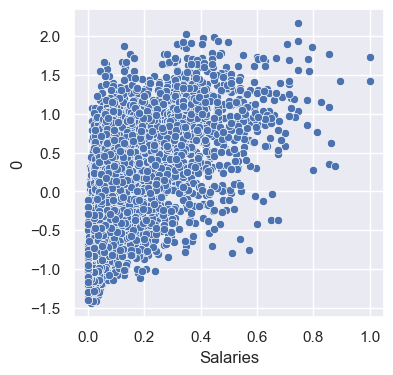

In [554]:
sns.set(rc={'figure.figsize':(4,4)})
sns.scatterplot(x=temp_df.Salaries, y=transformed_pca[0])

<AxesSubplot: xlabel='Salaries', ylabel='1'>

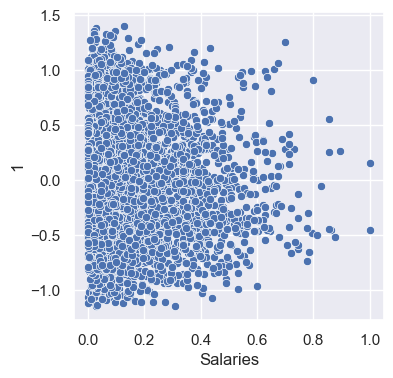

In [555]:
sns.scatterplot(x=temp_df.Salaries, y=transformed_pca[1])

<AxesSubplot: xlabel='Salaries', ylabel='2'>

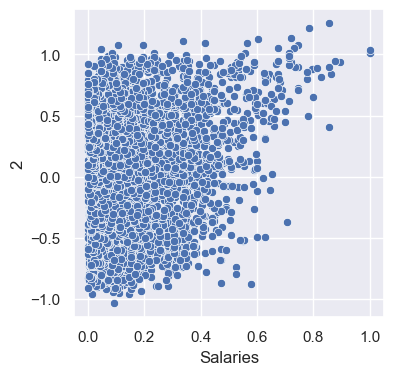

In [556]:
sns.scatterplot(x=temp_df.Salaries, y=transformed_pca[2])

In [557]:
correlation_target_and_pca = transformed_pca.apply(lambda x: x.corr(temp_df.Salaries))
print("Correlation between PCA and Salaries:")
print(correlation_target_and_pca)

Correlation between PCA and Salaries:
0    0.600283
1   -0.069053
2    0.219501
dtype: float64


Text(0.5, 1.0, 'Besar korelasi (mutlak) masing-masing kolom dengan Salaries')

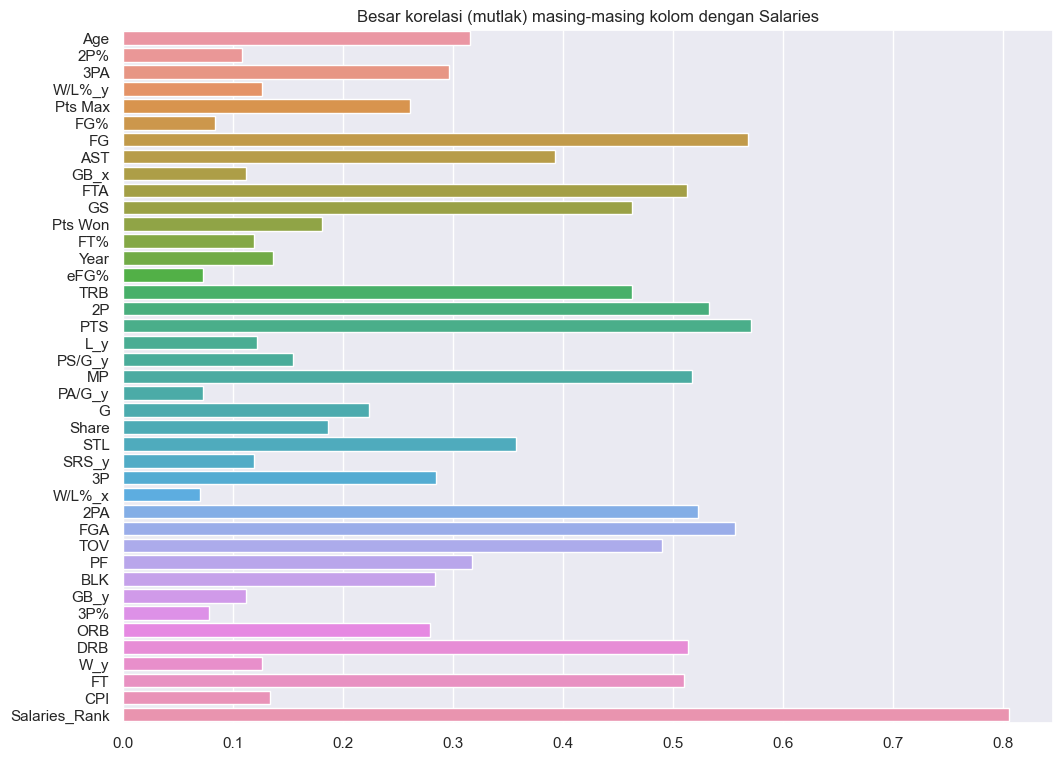

In [558]:
salaries = temp_df.Salaries
temp_df2 = temp_df.drop('Salaries', axis=1)
correlation_target_and_all_columns = temp_df2.apply(lambda x: x.corr(salaries))

sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(y=temp_df2.columns, x=abs(correlation_target_and_all_columns), orient="h")
plt.title("Besar korelasi (mutlak) masing-masing kolom dengan Salaries")

### 2B. Drop missing values pada target feature

kami memutuskan untuk mendrop missing values pada target feature karena target feature merupakan ground truth. Oleh karena itu, kami tidak setuju apabila kita melakukan imputasi untuk missing values pada kolom ini. Sebab, apabila kita melakukan imputasi terhadap missing values untuk kolom ini, maka kolom ini tidak sepenuhnya menjadi ground truth lagi karena diisikan dengan data-data sintesis yang tidak diketahui kebenarannya.

In [559]:
print("Banyak missing values pada kolom Salaries sebelum drop: ", combined_df.Salaries.isna().sum())
combined_df = combined_df[combined_df.Salaries.notna()]
print("Banyak missing values pada kolom Salaries setelah drop: ", combined_df.Salaries.isna().sum())

Banyak missing values pada kolom Salaries sebelum drop:  390
Banyak missing values pada kolom Salaries setelah drop:  0


### 2B. Memisahkan kolom-kolom menjadi feature (X) dan target (y) dan drop fitur-fitur yang tidak diperlukan

Pada dataset ini, kita sudah memiliki gabungan seluruh feature mengenai statistik performa team dan statistik performa pemain. Oleh karena itu, nama tim dan nama pemain sudah tidak lagi berkaitan dengan gaji yang diperoleh. Nama tim sudah dapat digantikan dengan data mengenai performa tim, dan nama pemain dapat digantikan dengan data mengenai performa pemain.

Sementara itu, kita melakukan drop kolom Rank karena kolom tersebut merupakan Ranking gaji seorang pemain pada tahun itu. Oleh karena itu, kami merasa informasi ini tidak valid untuk dijadikan dasar dalam memprediksi gaji pemain.

In [560]:
x_2b, y_2b = combined_df.drop("Salaries", axis=1), combined_df[["Salaries"]]
x_2b.drop("Team", axis=1, inplace=True)
x_2b.drop("Player", axis=1, inplace=True)
x_2b.drop("Salaries_Rank", axis=1, inplace=True)

display(x_2b.head(2))
display(y_2b.head(2))

,Age,2P%,3PA,W/L%_y,Pts Max,FG%,FG,AST,GB_x,FTA,...,TOV,PF,BLK,GB_y,3P%,ORB,DRB,W_y,FT,CPI
0,27,575.0,0.0,81.707317,1210,574.0,12.1,3.8,0.0,10.4,...,2.8,3.2,3.0,NaN,0.00,4.3,9.4,67,5.5,172.6
1,23,504.0,1.0,60.975610,1210,497.0,9.4,5.0,5.0,5.0,...,3.3,2.5,1.6,5.0,0.37,2.8,9.0,50,3.8,172.6


,Salaries
0,17142000.0
1,16806000.0


### 2B. Membagi dataset menjadi training, testing, dan final testing

Kami memutuskan untuk membagi dataset menjadi training, testing, dan final testing. Dataset final testing diperlukan karena kita sangat disarankan untuk memasuki fase testing hanya sekali saja, yakni ketika kita sudah benar-benar yakin dengan model yang kita bangun dan sudah tidak ingin mengutak-atik modelnya lagi. Oleh karena itu, kami memutuskan untuk membagi dataset testing menjadi testing untuk mengecek performa, dan final testing untuk model yang sudah final.

In [561]:
x_2b_train, x2b_final_test, y_2b_train, y_2b_final_test = train_test_split(
    x_2b, y_2b, test_size=0.2, random_state=random_state
)
del x_2b
del y_2b

x_2b_train, x2b_test, y_2b_train, y_2b_test = train_test_split(
    x_2b_train, y_2b_train, test_size=0.2, random_state=random_state,
)

### 2B Pipeline Design, Training model, dan Hyperparameter tuning

Pada bagian ini, kita akan merancang pipeline mengenai alur pemrosesan data. Pipeline ini memiliki 5 tahapan: *encode* data kategorikal, menerapkan *scaling* & *standarisasi*, mengisi *missing values*, menerapkan *feature selection* , dan melakukan *training*/prediksi.

Beberapa tahapan dapat memiliki beberapa alternatif yang ingin dicoba. Misalnya, pada tahapan standarisasi kami mencoba metode MinMaxScaler, StandardScaler, RobustScaler, dan tanpa scaling. Setelah itu kami akan memilih metode yang menghasilkan akurasi terbaik. Oleh karena itu, kami akan memanfaatkan `GridSearchCV` untuk mencoba semua kombinasi tersebut.

Pada bagian ini, kami mempertimbangkan untuk tidak menghapus outlier karena kami mengasumsikan bahwa outlier pada dataset memang merupakan sifat alami dari data dan tidak diakibatkan oleh kesalahan pengukuran apapun. Karena outlier tersebut merupakan data alami, akan lebih baik apabila kami membiarkannya saja.

In [562]:
def cartesian_product_of_dict_lists(*multiple_list_of_dicts):
    if len(multiple_list_of_dicts) == 0:
        return []

    if len(multiple_list_of_dicts) == 1:
        return multiple_list_of_dicts[0]

    if len(multiple_list_of_dicts) == 2:
        ret = []
        for dict1 in multiple_list_of_dicts[0]:
            for dict2 in multiple_list_of_dicts[1]:
                ret.append(dict(**dict1, **dict2))
        return ret

    curr = [{}]
    for dct in multiple_list_of_dicts:
        curr = cartesian_product_of_dict_lists(curr, dct)
    return curr

In [563]:
class DataFrameCaptor(TransformerMixin):
    """Untuk mendapatkan contoh dataframe pada tahap tertentu di dalam pipeline"""
    def __init__(self):
        self.captured_fit_x = None
        self.captured_fit_y = None
        self.captured_transform_x = None
        self.captured_transform_y = None

    def fit(self, x, y=0):
        self.captured_fit_x = x
        self.captured_fit_y = y
        return self

    def transform(self, x, y=0):
        self.captured_transform_x = x
        self.captured_transform_y = y
        return x

    def get_captured_fit(self):
        return self.captured_fit_x, self.captured_fit_y

    def get_captured_transform(self):
        return self.captured_transform_x, self.captured_transform_y

In [564]:
from sklearn.base import TransformerMixin #gives fit_transform method for free

# LabelEncoder tidak dapat dimasukkan ke dalam pipeline karena
# LabelEncoder.transform() hanya memiliki 1 parameter, sedangkan pipeline akan memberikan 2 parameter

class MyLabelEncoder(TransformerMixin):
    # source: https://stackoverflow.com/a/46619402/7069108
    def __init__(self, columns_to_be_encoded:dict[str, list[str]],
                 *args, **kwargs):
        """
        :param columns_to_be_encoded: dictionary, di mana keys-nya menyatakan kolom-kolom apa saja yang ingin di-encode, dan values-nya menyatakan list daftar semua nilai-nilai pada kelas kategorikal tersebut. None jika kita ingin mengambil berdasarkan fit yang diberikan pada MyLabelEncoder ini

        :param args:
        :param kwargs:
        """
        self.encoders = {
            column: preprocessing.LabelEncoder(*args, **kwargs)
                for column in columns_to_be_encoded.keys()
        }
        self.possible_values = columns_to_be_encoded
        for col, possible_values in columns_to_be_encoded.items():
            if possible_values is None:
                continue
            self.encoders[col].fit(possible_values)

    def fit(self, x, y=0):
        for col, encoder in self.encoders.items():
            possible_values = self.possible_values[col]
            if possible_values is None:
                encoder.fit(x[col])
                continue
        return self

    def transform(self, x, y=0):
        x = x.copy()
        for col, encoder in self.encoders.items():
            x[col] = encoder.transform(x[col])
        return x

In [565]:
class OrderedMultiClassOneHotEncoder:
    """
    Class untuk melakukan one-hot encoding, di mana satu data bisa tergolong ke dalam 2 kelas yang berbeda. Misal Pos='SF-SG' berarti data tersebut tergolong ke dalam pos "SF" dan pos "SG" sekaligus.
    Namun, akan ada perbedaan bobot untuk pos-pos ini. Pos yang hanya terdiri dari satu kelas saja
    misalnya seperti Pos='C', akan diberikan bobot 1 pada kolom C. Pos yang terdiri dari 2 kelas,
    misalnya Pos='SF-SG', akan diberikan bobot 2/3 pada kelas pertama (SF), dan 1/3 pada kelas kedua (SG).
    """
    def __init__(self, target_col="Pos",
                 base_classes=('C', 'PF', 'SF', 'PG', 'SG'),
                 separator="-"):
        self.target_col = target_col
        self.base_classes = base_classes
        self.separator = separator

    def fit(self, x, y=0):
        return self

    def _get_col_name(self, class_name):
        return f"{self.target_col}_{class_name}"

    def transform(self, x, y=0):
        column_values = x[self.target_col]
        x = x.drop(self.target_col, axis=1)
        for base_class in self.base_classes:
            x[self._get_col_name(base_class)] = 0

        for ind, val in enumerate(column_values):
            classes =  val.split(self.separator)
            weights = [i for i in range(len(classes), 0, -1)]  # len, len-1, len-2, ..., 2, 1
            sum_ = sum(weights)

            for class_, weight in zip(classes, weights):
                class_ = self._get_col_name(class_)
                col = x.columns.get_loc(class_)
                x.iloc[ind, col] = weight / sum_
        return x

In [566]:
label_encoder_params = [{
    'encoding': [
        MyLabelEncoder({
            "Pos": ['C', 'PF', 'SF', 'PG', 'SG', 'SF-SG', 'C-PF', 'PG-SG', 'SF-PF',
                    'PG-SF', 'PF-C', 'SG-SF', 'SG-PG', 'PF-SF', 'SG-PF']
        }),
        OrderedMultiClassOneHotEncoder("Pos", ['C', 'PF', 'SF', 'PG', 'SG'], "-"),
    ]
}]

In [567]:
scaler1 = preprocessing.MinMaxScaler()
scaler2 = preprocessing.StandardScaler()
scaler3 = preprocessing.RobustScaler()

scaler_params = [{
    'scaler': [None, scaler3, scaler2, scaler1],
}]

In [568]:
imputer1 = SimpleImputer()
imputer2 = KNNImputer()

imputer_params = [{
    'imputer': [imputer2, imputer1],
}]

Berikut ini kami mempertimbangkan SelectKBest untuk k bernilai 6 dan 7. Jumlahnya fitur yang dipilih disarankan adalah sqrt(N); N=banyaknya fitur. Oleh karena itu kami mencoba 6 dan 7 sebagai nilai k karena N=45; sqrt(N) sekitar 6 atau 7.

Source: https://datascience.stackexchange.com/a/11480/141286

In [569]:
len(combined_df.columns)

45

In [570]:
feature_selector_params = [{
    'feature_selector': [SelectFromModel(estimator=Lasso())],
    'feature_selector__estimator__alpha': [3.0, 2.4, 1.8, 1.2,]
}, {
    'feature_selector': [SelectKBest()],
    'feature_selector__k': [6, 7],
}, {
    'feature_selector': [PCA()],
    'feature_selector__n_components': ['mle']
}]

Kami sudah mencoba GridSearcCV untuk membandingkan model KNeighborsRegressor, LinearRegression, MLPRegressor (relu & tanh), dan RandomForestRegressor. Hasilnya, urutan model mulai dari yang terbaik hingga yang terburuk adalah RandomForestRegressor, LinearRegression, KNeighborsRegressor, dan MLPRegressor.

Setelah itu, kami juga sudah membandingkan RandomForestRegressor dengan SVR, BaggingRegressor(SVR()), BaggingRegressor(LinearRegression()), dan BaggingRegressor(KNeighborsRegressor()). Hasilnya, RandomForestRegressor masih tetap memberikan prediksi yang terbaik.

Oleh karena itu, di antara model-model yang sudah dicoba tersebut, kami mempertimbangkan untuk hanya memasukkan model RandomForestRegressor ke dalam GridSearchCV supaya menghemat biaya komputasi.

In [571]:
predictor_params = [{
    'predictor': [
        RandomForestRegressor(random_state=42),
    ],
}]

In [572]:
pipeline = Pipeline(
    steps=[
        ('encoding', None),
        ('df_captor', DataFrameCaptor()),
        ('scaler', None),
        ('imputer', None),
        ('feature_selector', None),
        ('predictor', None),
    ]
)

In [573]:
grid_params = cartesian_product_of_dict_lists(
    label_encoder_params,
    scaler_params,
    imputer_params,
    feature_selector_params,
    predictor_params
)

In [574]:
grid_params

[{'encoding': [<__main__.MyLabelEncoder at 0x1d147960580>,
  'scaler': [None, RobustScaler(), StandardScaler(), MinMaxScaler()],
  'imputer': [KNNImputer(), SimpleImputer()],
  'feature_selector': [SelectFromModel(estimator=Lasso())],
  'feature_selector__estimator__alpha': [3.0, 2.4, 1.8, 1.2],
  'predictor': [RandomForestRegressor(random_state=42)]},
 {'encoding': [<__main__.MyLabelEncoder at 0x1d147960580>,
  'scaler': [None, RobustScaler(), StandardScaler(), MinMaxScaler()],
  'imputer': [KNNImputer(), SimpleImputer()],
  'feature_selector': [SelectKBest()],
  'feature_selector__k': [6, 7],
  'predictor': [RandomForestRegressor(random_state=42)]},
 {'encoding': [<__main__.MyLabelEncoder at 0x1d147960580>,
  'scaler': [None, RobustScaler(), StandardScaler(), MinMaxScaler()],
  'imputer': [KNNImputer(), SimpleImputer()],
  'feature_selector': [PCA()],
  'feature_selector__n_components': ['mle'],
  'predictor': [RandomForestRegressor(random_state=42)]}]

In [575]:
def perform_grid_search_cv():
    grid_search_cv = GridSearchCV(
        estimator=pipeline,
        param_grid=grid_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=10,
        error_score='raise',
    )

    grid_search_cv.fit(x_2b_train, y_2b_train.Salaries)
    return grid_search_cv

In [576]:
file_name = "grid_search_cv_2b.pkl"
# Jika hasil GridSearchCV sudah tersimpan pada file, langsung dipakai saja. Jika belum, maka
# terapkan grid GridSearchCV
try:
    grid_search_cv = joblib.load(file_name)
except FileNotFoundError:
    # sekitar 18 menit pada laptop i7  6 core  ram 24 GB
    grid_search_cv = perform_grid_search_cv()
    joblib.dump(grid_search_cv, file_name)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


H:\01 Kuliah\01 Dokumen\52 - KASDD\proyek-akhir\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.086e+16, tolerance: 1.397e+13
  model = cd_fast.enet_coordinate_descent(


In [577]:
# Get the scores for all hyperparameter combinations
cv_results = grid_search_cv.cv_results_
scores = []
for params_combination in cv_results['params']:
    score = cv_results['mean_test_score'][cv_results['params'].index(params_combination)]
    scores.append((score, params_combination))

# sort berdasarkan score terbesar (berdasarkan error yang terkecil)
scores.sort(reverse=True, key=lambda x: x[0])

print("Urutan parameter & model yang terbaik hingga terburuk: ")
print()
print()
# Print the scores for each combination
for score, params_combination in scores:
    print("Score: ", score)
    print(f"{params_combination}")
    print()

Urutan parameter & model yang terbaik hingga terburuk: 


Score:  -10367093461595.814
{'encoding': <__main__.OrderedMultiClassOneHotEncoder object at 0x000001D147961900>, 'feature_selector': SelectFromModel(estimator=Lasso(alpha=3.0)), 'feature_selector__estimator__alpha': 3.0, 'imputer': SimpleImputer(), 'predictor': RandomForestRegressor(random_state=42), 'scaler': StandardScaler()}

Score:  -10367093461595.814
{'encoding': <__main__.OrderedMultiClassOneHotEncoder object at 0x000001D147961900>, 'feature_selector': SelectFromModel(estimator=Lasso(alpha=3.0)), 'feature_selector__estimator__alpha': 2.4, 'imputer': SimpleImputer(), 'predictor': RandomForestRegressor(random_state=42), 'scaler': StandardScaler()}

Score:  -10367093461595.814
{'encoding': <__main__.OrderedMultiClassOneHotEncoder object at 0x000001D147961900>, 'feature_selector': SelectFromModel(estimator=Lasso(alpha=3.0)), 'feature_selector__estimator__alpha': 1.8, 'imputer': SimpleImputer(), 'predictor': RandomForestRegres

### 2B testing

In [578]:
best_pipeline = grid_search_cv.best_estimator_

y_2b_predict = best_pipeline.predict(x2b_test)
mae = metrics.mean_absolute_error(y_2b_test, y_2b_predict)
r2 = metrics.r2_score(y_2b_test, y_2b_predict)

print("R2 score: ", r2)
print("Rata-rata error absolut: ", mae)
print("Rata-rata error relatif: ", mae / y_2b_test.Salaries.mean())

R2 score:  0.6265223403576891
Rata-rata error absolut:  2114031.61392126
Rata-rata error relatif:  0.45893369679209933


In [579]:
best_pipeline

Pipeline(steps=[('encoding',
                 <__main__.OrderedMultiClassOneHotEncoder object at 0x000001D15682DBD0>),
                ('df_captor',
                 <__main__.DataFrameCaptor object at 0x000001D15682E290>),
                ('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('feature_selector',
                 SelectFromModel(estimator=Lasso(alpha=3.0))),
                ('predictor', RandomForestRegressor(random_state=42))])

In [580]:
grid_search_cv.best_params_

{'encoding': <__main__.OrderedMultiClassOneHotEncoder at 0x1d147961900>,
 'feature_selector': SelectFromModel(estimator=Lasso(alpha=3.0)),
 'feature_selector__estimator__alpha': 3.0,
 'imputer': SimpleImputer(),
 'predictor': RandomForestRegressor(random_state=42),
 'scaler': StandardScaler()}

In [581]:
captured_df, *_ = best_pipeline['df_captor'].get_captured_fit()

print("Fitur-fitur terbaik: ")
print()
print(", ".join(
    best_pipeline['feature_selector'].get_feature_names_out(input_features=captured_df.columns)
))

Fitur-fitur terbaik: 

Age, 2P%, 3PA, W/L%_y, Pts Max, FG%, FG, AST, GB_x, FTA, GS, Pts Won, FT%, Year, eFG%, TRB, 2P, PTS, L_y, PS/G_y, MP, PA/G_y, G, Share, STL, SRS_y, 3P, W/L%_x, 2PA, FGA, TOV, PF, BLK, GB_y, 3P%, ORB, DRB, W_y, FT, CPI, Pos_C, Pos_PF, Pos_SF, Pos_PG, Pos_SG


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])